In [2]:
### Load packages and data files
import csv
import glob
from collections import defaultdict
from datetime import datetime, date
from dateutil import parser
from __future__ import division
import numpy as np
from operator import add
from calendar import day_abbr
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

%matplotlib inline

In [3]:
def get_turnstile_data(Dates):
    
    ## Get all turnstile files from MTA given a list of desired dates
    ## ie ['160702','160625','160618','160611']
    url_template="http://web.mta.info/developers/data/nyct/turnstile/turnstile_%s.txt"
    
    for date in Dates:
        url = url_template % date
        !wget {url}    

In [4]:
def turnstile_read_csv(csv_files):
    
    ## Function to read all text files given a name handle, and store them in a list
    dict_MTA= defaultdict(list)
    MTA = [] 
    
    for filename in glob.glob(csv_files):
        file = open(filename, 'r')
        reader = csv.reader(file)
        header = reader.next()
        MTA = list(reader)
        
        for turnstile in MTA:
            turnstile[-1] = turnstile[-1].strip()    
            turnstile[4] = ''.join(sorted(turnstile[4]))
            turnstile_key = tuple(turnstile[0:5])
            dict_MTA[turnstile_key].append(turnstile[5:])
        
        file.close()
    
    return dict_MTA

In [5]:
# Downnload one month of data
get_turnstile_data(['160702','160625','160618','160611'])

In [6]:
num_weeks = 4

In [7]:
# Read all text files and Store in a List
dict_MTA = turnstile_read_csv("turnstile_*.txt")

In [8]:
# Sanity check
dict_MTA[('R148','R033','01-03-00','TIMES SQ-42 ST','1237ACENQRS')][0:10]

[['IRT', '06/04/2016', '00:00:00', 'REGULAR', '0003699709', '0001186414'],
 ['IRT', '06/04/2016', '04:00:00', 'REGULAR', '0003699738', '0001186414'],
 ['IRT', '06/04/2016', '08:00:00', 'REGULAR', '0003699743', '0001186418'],
 ['IRT', '06/04/2016', '12:00:00', 'REGULAR', '0003699821', '0001186444'],
 ['IRT', '06/04/2016', '16:00:00', 'REGULAR', '0003699922', '0001186509'],
 ['IRT', '06/04/2016', '20:00:00', 'REGULAR', '0003700084', '0001186580'],
 ['IRT', '06/05/2016', '00:00:00', 'REGULAR', '0003700214', '0001186582'],
 ['IRT', '06/05/2016', '04:00:00', 'REGULAR', '0003700256', '0001186582'],
 ['IRT', '06/05/2016', '08:00:00', 'REGULAR', '0003700259', '0001186583'],
 ['IRT', '06/05/2016', '12:00:00', 'REGULAR', '0003700314', '0001186615']]

In [10]:
#%store dict_MTA

## Get counts per interval

In [11]:
def time_series(dict_MTA):
    dict_MTA_ts = {}
    
    for key in dict_MTA.keys():
    # For each turnstile key get the number or entries+exits by 4 hr time interval 
        dict_MTA_ts[key] = []
        
        for i in range(0, len(dict_MTA[key])):
            time_stamp = parser.parse('%sT%s' % (dict_MTA[key][i][1], dict_MTA[key][i][2])) 
            four_hr_ct_entry = int(dict_MTA[key][i][4]) - int(dict_MTA[key][i-1][4])
            four_hr_ct_exit = int(dict_MTA[key][i][5]) - int(dict_MTA[key][i-1][5])

            if four_hr_ct_entry < 0 or four_hr_ct_entry > 4*60*60:  
            # Avoid negative or exagerated records max 4*60*60 per turnstile per 4h
                four_hr_ct_entry = np.nan
            if four_hr_ct_exit < 0 or four_hr_ct_exit > 4*60*60:
                four_hr_ct_exit = np.nan
            
            if np.isnan([four_hr_ct_entry,four_hr_ct_exit]).all():
                dict_MTA_ts[key].append([time_stamp, np.nan])
            else:                          
                dict_MTA_ts[key].append([time_stamp, np.nansum([four_hr_ct_entry,four_hr_ct_exit])])
                
    return dict_MTA_ts

In [12]:
# Run all time series
dict_MTA_ts = time_series(dict_MTA)

In [13]:
%store dict_MTA_ts

Stored 'dict_MTA_ts' (dict)


In [14]:
dict_MTA_ts[('R148','R033','01-03-00','TIMES SQ-42 ST','1237ACENQRS')][0:10]

[[datetime.datetime(2016, 6, 4, 0, 0), nan],
 [datetime.datetime(2016, 6, 4, 4, 0), 29],
 [datetime.datetime(2016, 6, 4, 8, 0), 9],
 [datetime.datetime(2016, 6, 4, 12, 0), 104],
 [datetime.datetime(2016, 6, 4, 16, 0), 166],
 [datetime.datetime(2016, 6, 4, 20, 0), 233],
 [datetime.datetime(2016, 6, 5, 0, 0), 132],
 [datetime.datetime(2016, 6, 5, 4, 0), 42],
 [datetime.datetime(2016, 6, 5, 8, 0), 4],
 [datetime.datetime(2016, 6, 5, 12, 0), 87]]

## Merge per station per morning of the week

In [15]:
def combine_into_stations(dict_MTA_ts):
    dict_stations_AM = defaultdict(list)
    
    for key in dict_MTA_ts:
        station_key = '_'.join((key[3],key[4]))
        
        for interval in dict_MTA_ts[key]:
            if (4 <= interval[0].hour and interval[0].hour <= 13):
            # Get 4/5-12/13 hours counts and append per station
            # Mondays indexed 0
                dict_stations_AM[station_key].append([interval[0].weekday(), interval[0].hour, interval[1]])
                
    return dict_stations_AM

In [16]:
# Applying fn to merge per morning of week by station, still get entry per turnstile
dict_stations_AM = combine_into_stations(dict_MTA_ts)

In [17]:
# Sanity check
dict_stations_AM['TIMES SQ-42 ST_1237ACENQRS'][:10]

[[5, 4, 50],
 [5, 8, 49],
 [5, 12, 307],
 [6, 4, 0],
 [6, 8, 27],
 [6, 12, 223],
 [0, 4, 0],
 [0, 8, 61],
 [0, 12, 658],
 [1, 4, 0]]

## Get dictionary for average per day --      `station:[avg count from Mon AM, for Tues AM, ...]`

In [18]:
def average_by_weekday(dict_stations_AM):
    dict_by_day = defaultdict(list)
    
    for key in dict_stations_AM:
        dict_by_day[key] = [0]*7
       
        for entry in dict_stations_AM[key]:
            if ~np.isnan(entry[2]):    # Will be np.nan if <0 or too large to be possible.
                dict_by_day[key][entry[0]] += entry[2]

        dict_by_day[key] = np.array(dict_by_day[key])/num_weeks
        
    return dict_by_day

In [19]:
dict_average_by_weekday = average_by_weekday(dict_stations_AM)

In [20]:
dict_average_by_weekday['TIMES SQ-42 ST_1237ACENQRS']

array([ 65082.  ,  66893.75,  68220.  ,  68111.75,  62437.  ,  32908.75,
        27444.5 ])

In [21]:
# Get top transited stations, numbers are the average morning transit per week
dict_total_pStation = []

for station,week_counts in dict_average_by_weekday.iteritems():
    dict_total_pStation.append((station, sum(week_counts)))

In [22]:
dict_total_pStation.sort(key=lambda x:x[1], reverse=True)
dict_total_pStation[:15]

[('GRD CNTRL-42 ST_4567S', 692888.75),
 ('34 ST-HERALD SQ_BDFMNQR', 465660.0),
 ('14 ST-UNION SQ_456LNQR', 418438.75),
 ('TIMES SQ-42 ST_1237ACENQRS', 391097.75),
 ('34 ST-PENN STA_ACE', 355639.0),
 ('FULTON ST_2345ACJZ', 318631.5),
 ('42 ST-PORT AUTH_1237ACENQRS', 293577.5),
 ('47-50 STS ROCK_BDFM', 287950.25),
 ('FLUSHING-MAIN_7', 274810.25),
 ('86 ST_456', 262053.75),
 ('59 ST_456NQR', 255925.0),
 ('59 ST COLUMBUS_1ABCD', 252498.25),
 ('JKSN HT-ROOSVLT_7EFMR', 213792.0),
 ('LEXINGTON AV/53_6EM', 205158.25),
 ('96 ST_123', 193078.5)]

## Create Dictionary by Neighborhood

In [23]:
# Using file with Station - Neighborhood 
neighbor_key = defaultdict()

with open ('Neighborhoods.csv') as csv_file:
    data = csv.reader(csv_file)
    
    for line in data:
        neighbor_key[line[0]] = line[1]

In [24]:
# Get the total people transit per neighborhood
neighbor_influx = defaultdict(list)

for station in neighbor_key.keys():
    hood = neighbor_key[station]
    
    if any(neighbor_influx[hood]):
        neighbor_influx[hood] = map(add, neighbor_influx[hood],dict_average_by_weekday[station])
    else:
        neighbor_influx[hood] = dict_average_by_weekday[station]

In [25]:
# Get top transited neighborhoods, numbers in average morning transit per week
dict_total_pHood = []

for hood,week_counts in neighbor_influx.iteritems():
    dict_total_pHood.append((hood, sum(week_counts)))

In [26]:
dict_total_pHood.sort(key=lambda x:x[1], reverse=True)
dict_total_pHood[:10]

[('MIDTOWN EAST', 1741140.5),
 ('CHELSEA', 1740036.25),
 ('UNION SQ/GRAMERCY', 1418779.25),
 ('LOWER MANHATTAN', 1270688.0),
 ('UPPER WEST SIDE', 871426.0),
 ('UPPER EAST SIDE', 791825.5),
 ('EAST VILLAGE/LES', 699402.5),
 ('MIDTOWN WEST', 617018.0),
 ('SOHO/TRIBECA', 582806.5),
 ('HARLEM/HAMILTON HEIGHTS', 400852.5)]

In [27]:
# Top 10 neighborhoods
top10_hoods = [x[0] for x in dict_total_pHood][:10]

In [28]:
# 5 top where blue bottle is not present, and color code
BB_5_hoods = ['UNION SQ/GRAMERCY','LOWER MANHATTAN','UPPER WEST SIDE','UPPER EAST SIDE','EAST VILLAGE/LES']
BB_5_hoods_col = ['orange', 'y', 'yellow', 'indianred','c']

## Create Dictionary with neighborhoods as key and values as:
## `[weekday total, weekend total, week total]`

In [29]:
def weekday_end_total(influx):
    # Returns the average for weekdays/weekends/all_Week
    by_week = defaultdict(list)
    
    for hood in influx.keys():
        weekdays = sum(influx[hood][0:5])
        weekends = sum(influx[hood][5:7])
        week = weekdays + weekends

        by_week[hood] = [weekdays, weekends, week]
        
    return by_week

In [30]:
# All Manhattan station used
all_stations = neighbor_key.keys()

# Weekday/weekend/total average transit per station and neighborhood
mta_neighbor = weekday_end_total(neighbor_influx)
mta_station = weekday_end_total(dict_average_by_weekday)

# Dictionary of only Manhattan stations
Manhattan_stations = defaultdict(list)

for key in mta_station:
    if key in all_stations:
        Manhattan_stations[key] = mta_station[key]

In [31]:
Manhattan_stations['34 ST-PENN STA_123ACE']

[156639.5, 13849.5, 170489.0]

## Plot top neighborhoods by day of week

In [32]:
def sorted_graph(mta_turn, top, sort_val, color, title, stacked):
    # Function to plot bargraphs for a given top rank
    
    x, x1, x2, y, my_yticks, count = [],[],[],[],[],0
    plt.figure()
    
    if sort_val == 2 and stacked == 1:
        # Stack bar graph
        
        # Ranking for a given dictionary
        sortedByKeyDict = sorted(mta_turn.items(), key=lambda x: x[1][sort_val], reverse=False)

        for mta_keys, curVal in sortedByKeyDict[-top:]:
            x1.append(curVal[0])
            x2.append(curVal[1])
            my_yticks.append(mta_keys)
            y.append(count)
            count = count + 1
            
        plt.barh(y, x1, label = 'Weekday', color='navy', align="center")
        plt.barh(y, x2, left = x1, label = 'Weekend', color='royalblue', align="center")

    else:
        # Regular bargraph
        
        # Ranking for a given dictionary
        sortedByKeyDict = sorted(mta_turn.items(), key = lambda x: x[1][sort_val], reverse=False)

        for mta_keys, curVal in sortedByKeyDict[-top:]:
            x.append(curVal[sort_val])
            my_yticks.append(mta_keys)
            y.append(count)
            count = count + 1

        plt.barh(y, x, color=color, align="center")
       
    plt.title(title)
    plt.yticks(y, my_yticks)
    plt.xlabel('Average morning commuters per week')
    plt.legend(loc=4)
    

In [33]:
def neighborhood_top_stations(hood, station_hood, mta_stations):
    # Return the most transited stations per neighborhood
    
    hood_stations = defaultdict(list)
    counter = 0
    
    for station in mta_stations.keys():
        cur_hood = station_hood[station]
        if cur_hood == hood:
            hood_stations[station] = mta_station[station]
            
    return hood_stations

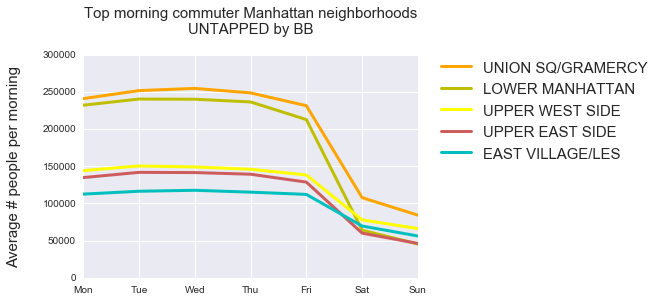

In [34]:
# Plot average transit by morning/weekday in the top10 transited neighborhoods
my_xticks = [x for x in day_abbr]

for hood,col in zip(BB_5_hoods,BB_5_hoods_col):     
    plt.plot(range(0,7), neighbor_influx[hood], linewidth=3,color=col, label=hood)
    
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., prop = {'size':15})
plt.xticks(range(0,7), my_xticks)
plt.title('Top morning commuter Manhattan neighborhoods\nUNTAPPED by BB\n',fontsize='15')
plt.ylabel('Average # people per morning\n',fontsize=15) 
plt.show()

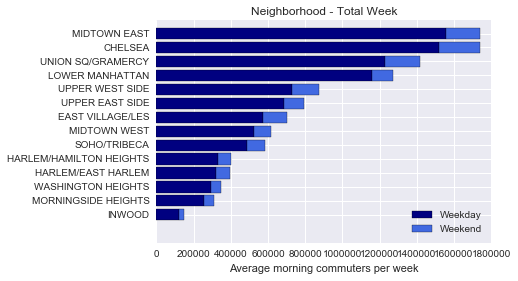

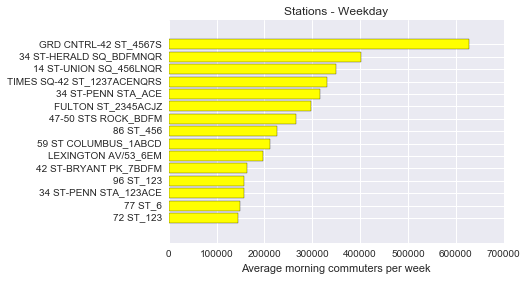

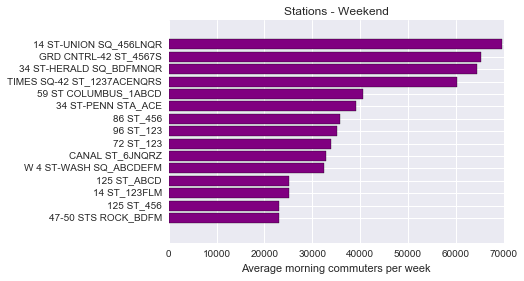

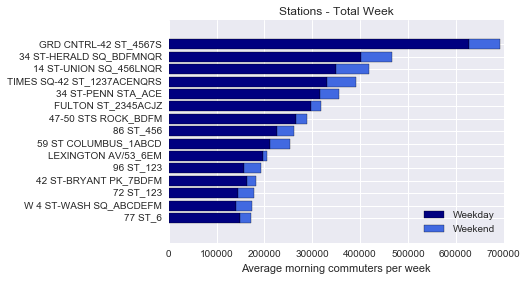

In [36]:
sorted_graph(mta_neighbor, 15, 2, 'green', 'Neighborhood - Total Week', 1)
sorted_graph(Manhattan_stations, 15, 0, 'yellow', 'Stations - Weekday', 0)
sorted_graph(Manhattan_stations, 15, 1, 'purple', 'Stations - Weekend', 0)
sorted_graph(Manhattan_stations, 15, 2, 'black', 'Stations - Total Week', 1)

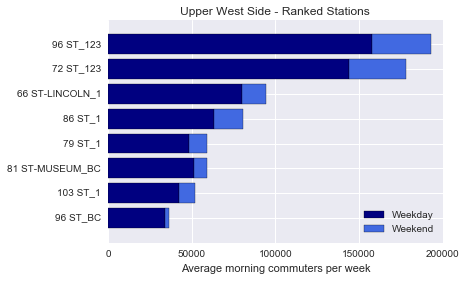

In [37]:
upper_west = neighborhood_top_stations("UPPER WEST SIDE", neighbor_key, Manhattan_stations)
sorted_graph(upper_west, 8, 2, 'yellow', 'Upper West Side - Ranked Stations', 1)

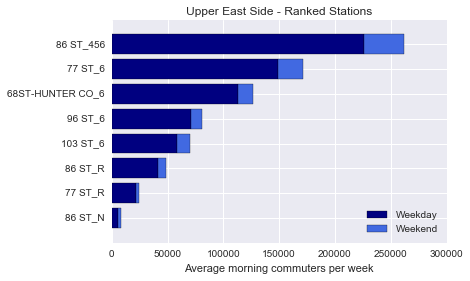

In [38]:
upper_east = neighborhood_top_stations("UPPER EAST SIDE", neighbor_key, Manhattan_stations)
sorted_graph(upper_east, 8, 2, 'indianred', 'Upper East Side - Ranked Stations', 1)